In [49]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, fftshift
import time
import glob as glob

In [50]:
# Auxiliary functions
def fft2_mod(image):

  shifted_image_fft = np.fft.fftshift(np.fft.fft2(image))
  return 20*np.log(np.abs(shifted_image_fft))


def _filter_round_shape(height, width, radius):
  canvas = np.zeros((height, width))
  return cv.circle(canvas,
                     center=(int(canvas.shape[1]/2), int(canvas.shape[0]/2)),
                     radius=radius,
                     color=(255),
                     thickness=-1).astype(np.uint8)


def create_lp_filter(height, width, radius=20):

  lp_filter = _filter_round_shape(height, width, radius)
  return lp_filter


def create_hp_filter(height, width, radius=60):

  lp_filter = _filter_round_shape(height, width, radius)
  return cv.bitwise_not(lp_filter)

# Punto 1

In [51]:
def create_gauss_filter(h, w, k_size, sigma):

    # Create gaussian kernel with k_size
    ax = np.linspace(-(k_size - 1) / 2., (k_size - 1) / 2., k_size) #(start, stop, samples)
    xx, yy = np.meshgrid(ax, ax)
    ksize_kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sigma))
    ksize_kernel_norm = (1/sum(sum(ksize_kernel)))*ksize_kernel 

    # Create gaussian kernel with w & h size
    ax = np.linspace(-(w - 1) / 2., (w - 1) / 2., w) #(start, stop, samples)
    ay = np.linspace(-(h - 1) / 2., (h - 1) / 2., h)
    xx, yy = np.meshgrid(ax, ay)
    kernel_norm = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sigma))

    # Transform the kernel to the spectral domain
    spectral_kernel_norm = np.fft.fft2((1/sum(sum(kernel_norm)))*kernel_norm)

    return (ksize_kernel_norm, kernel_norm, spectral_kernel_norm)

In [52]:
def apply_gauss(img, kernel):
    # Pass the kernel through the entire image
    img_filt = cv.filter2D(img, -1, kernel=kernel)
    return(img_filt)

In [53]:
# Read the image
img = cv.imread("pimiento_morron.jpg")

# Define parameters (k_size, h, w, sigma)
h,w= img.shape[:-1]
k_size = 15
sigma = 5

# Generate the kernel
ksize_kernel, gauss_filter, spectral_filter= create_gauss_filter(h, w, k_size , sigma)

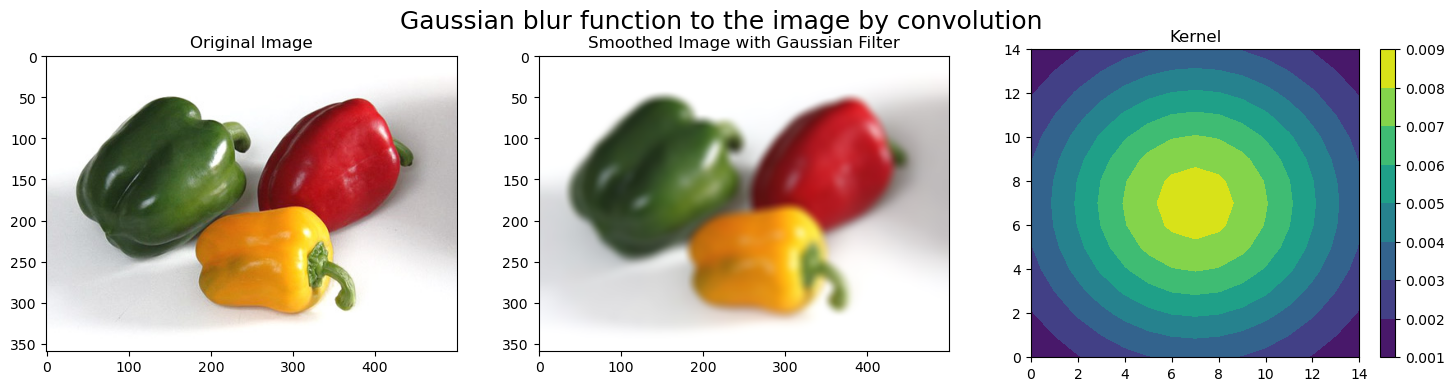

In [54]:
# Apply the Gaussian blur function to the image by convolution with ksize_kernel
gauss = apply_gauss(img, ksize_kernel)

# Display the original image, filtered image and kernel
plt.figure(figsize=(18, 4))
plt.suptitle('Gaussian blur function to the image by convolution', fontsize=18)
plt.subplot(131),plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)),plt.title('Original Image') 
plt.subplot(132),plt.imshow(cv.cvtColor(gauss, cv.COLOR_BGR2RGB)),plt.title('Smoothed Image with Gaussian Filter')
plt.subplot(133),plt.contourf(ksize_kernel),plt.title('Kernel'),plt.colorbar()
plt.show()


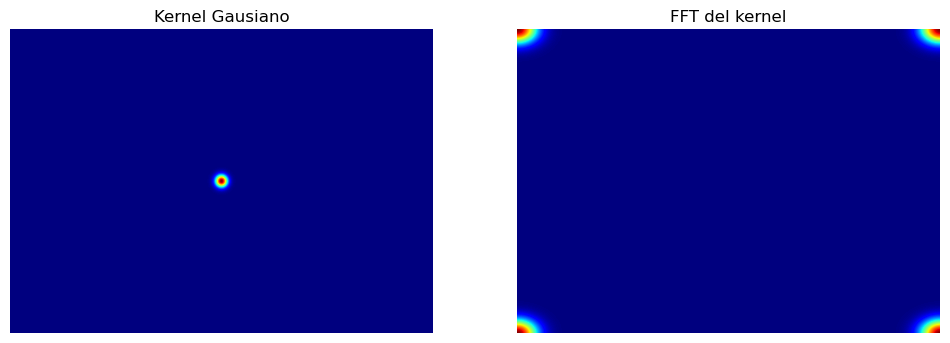

In [55]:
_, kernel, kernel_tf = create_gauss_filter(h, w, k_size=15, sigma=5)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.axis('off')
plt.title("Kernel Gausiano")
plt.imshow(kernel, cmap='jet')
plt.subplot(1,2,2)
plt.axis('off')
plt.title("FFT del kernel")
plt.imshow(np.abs(kernel_tf), cmap='jet')

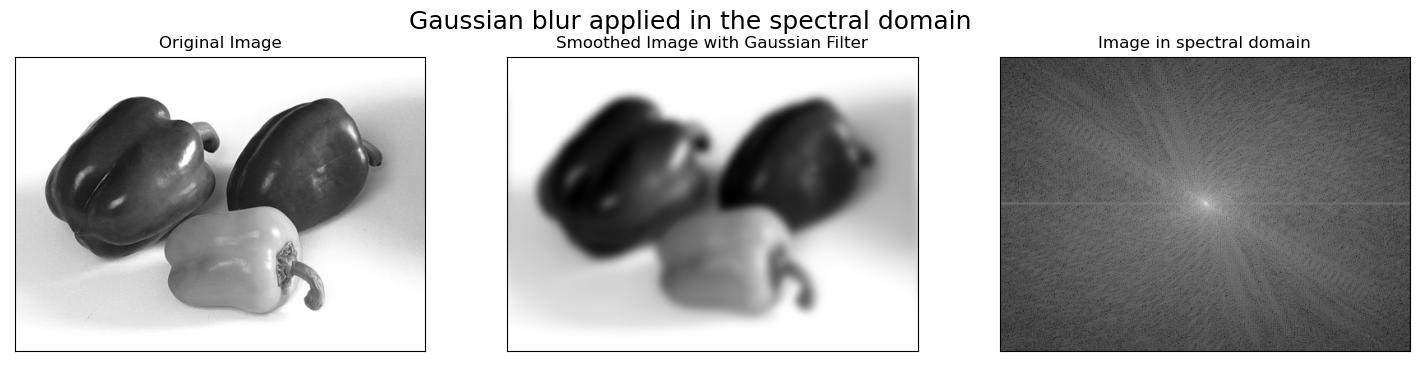

In [56]:
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_fft = np.fft.fft2(img_gray)
img_mod_fft = fft2_mod(img_gray)
filtered = img_fft * kernel_tf

img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))

# Display the original image, filtered image and its magnitude spectrum
plt.figure(figsize=(18, 4))
plt.suptitle('Gaussian blur applied in the spectral domain', fontsize=18)
plt.subplot(131), plt.imshow(img_gray, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(img_gauss, cmap='gray')
plt.title('Smoothed Image with Gaussian Filter'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(img_mod_fft, cmap='gray')
plt.title('Image in spectral domain'), plt.xticks([]), plt.yticks([])
plt.show()



# Punto 2

In [57]:
def result_blur(img):

    fourier_coefficients  = np.fft.fftshift(np.fft.fft2(img))

    # compute the absolute value of all Fourier coefficients
    abs_values = np.abs(fourier_coefficients)

    # compute the maximum value among all coefficients
    maximum_value = np.max(abs_values)

    # compute the total number of coefficients that are higher than the maximum value / 1000
    total = abs_values[abs_values > maximum_value / 1000].size
    result = (total / (img.size))
    return result

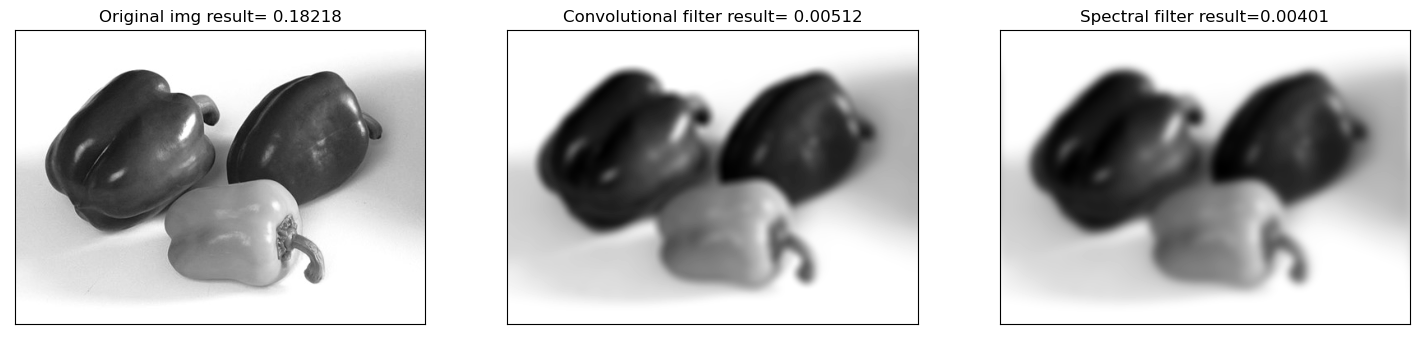

In [58]:
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Apply convolutional filter with Gaussian blur function
gauss = apply_gauss(img_gray, ksize_kernel)
result_blur(gauss)

# Apply spectral filter with Gaussian blur function 
img_fft = np.fft.fft2(img_gray)
filtered = img_fft * kernel_tf

img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))

result_blur(img_gauss)


# Plot the results
plt.figure(figsize=(18,10))
plt.subplot(1,3,2)
plt.title(f'Convolutional filter result= {result_blur(gauss):.5f}'), plt.xticks([]), plt.yticks([])
plt.imshow(gauss, 'gray')
plt.subplot(1,3,3)
plt.title(f'Spectral filter result={result_blur(img_gauss):.5f}'), plt.xticks([]), plt.yticks([])
plt.imshow(img_gauss, 'gray')
plt.subplot(1,3,1)
plt.title(f'Original img result= {result_blur(img):.5f}'), plt.xticks([]), plt.yticks([])
plt.imshow(img_gray, 'gray')
plt.show()

# Punto 3

Aplico uno de los metodos del paper - Gaussian derivative (GRA1)

In [59]:
def gaussian_derivative_focus_measure(img, W):
    # Compute the value of s for the given neighborhood size W
    s = W / 5
    
    # Compute the x and y partial derivatives of the image using the Sobel operator
    Gx = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=5)
    Gy = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=5)
    
    # Compute the focus measure for each pixel
    f = Gx**2 + Gy**2
    
    # Apply a Gaussian filter to the focus measure with the computed value of s
    f = cv.GaussianBlur(f, (W, W), s)

    # Compute the mean focus measure for the entire image
    mean_focus_measure = np.mean(f)
    
    return mean_focus_measure

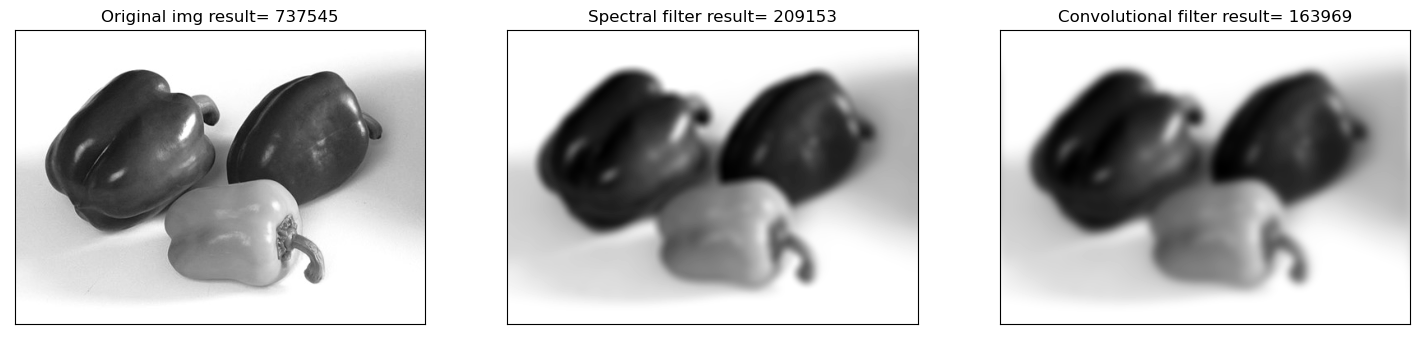

In [66]:
# Plot the results
plt.figure(figsize=(18,10))
plt.subplot(1,3,2)
plt.title(f'Spectral filter result= {gaussian_derivative_focus_measure(gauss, 1):.0f}'), plt.xticks([]), plt.yticks([])
plt.imshow(gauss, 'gray')
plt.subplot(1,3,3)
plt.title(f'Convolutional filter result= {gaussian_derivative_focus_measure(img_gauss, 1):.0f}'), plt.xticks([]), plt.yticks([])
plt.imshow(img_gauss, 'gray')
plt.subplot(1,3,1)
plt.title(f'Original img result= {gaussian_derivative_focus_measure(img_gray, 1):.0f}'), plt.xticks([]), plt.yticks([])
plt.imshow(img_gray, 'gray')
plt.show()